In [23]:
%matplotlib inline
from lxml import etree as ET
import codecs
import numpy as np
import re
from collections import defaultdict
import itertools
import matplotlib.pyplot as plt
import numpy as np

In [3]:
titles = []
with codecs.open("/media/christof/Harddrive/corpora/data/contemporary/source/rezeptewikiorg-20140325-titles.txt") as titles_file:
    for line in titles_file:
        titles.append(line.strip())


In [4]:
print len(titles)

33970


In [5]:
recipe_tree = ET.parse("/media/christof/Harddrive/corpora/data/contemporary/source/rezeptewikiorg-20140325-history.xml")

In [149]:
show_structure(recipe_tree)

-  {http://www.mediawiki.org/xml/export-0.6/}mediawiki
  \_ {http://www.mediawiki.org/xml/export-0.6/}siteinfo
    \_ {http://www.mediawiki.org/xml/export-0.6/}sitename
    \_ {http://www.mediawiki.org/xml/export-0.6/}base
    \_ {http://www.mediawiki.org/xml/export-0.6/}generator
    \_ {http://www.mediawiki.org/xml/export-0.6/}case
    \_ {http://www.mediawiki.org/xml/export-0.6/}namespaces
      \_ {http://www.mediawiki.org/xml/export-0.6/}namespace
     ...
   ...
  \_ {http://www.mediawiki.org/xml/export-0.6/}page
    \_ {http://www.mediawiki.org/xml/export-0.6/}title
    \_ {http://www.mediawiki.org/xml/export-0.6/}ns
    \_ {http://www.mediawiki.org/xml/export-0.6/}id
    \_ {http://www.mediawiki.org/xml/export-0.6/}redirect
    \_ {http://www.mediawiki.org/xml/export-0.6/}sha1
    \_ {http://www.mediawiki.org/xml/export-0.6/}revision
      \_ {http://www.mediawiki.org/xml/export-0.6/}id
      \_ {http://www.mediawiki.org/xml/export-0.6/}timestamp
      \_ {http://www.mediawiki.

In [51]:
recipe_tree_root = recipe_tree.getroot()
default_ns = recipe_tree_root.nsmap.get(None)
print len(recipe_tree_root)

33971


In [136]:
ingredient_counter = defaultdict(int)
recipe_ingredients = []
recipe_additionals = []
number_of_elems = 0
for elem in recipe_tree_root.iter("{"+default_ns+"}page"):
    title_elem = elem.find("{"+default_ns+"}title")
    text_elem = elem.find("{"+default_ns+"}revision").findall("{"+default_ns+"}text")[-1]
    is_about_ingredient = False
    is_about_adds = False
    if title_elem.text is not None and text_elem.text is not None:
        ingredients = []
        additionals = []
        for line in text_elem.text.split("\n"):
            if line.startswith("== Zutaten =="):
                is_about_adds = False
                is_about_ingredient = True
            if line.startswith("== Beilagen =="):
                is_about_ingredient = False
                is_about_adds = True
            line_ingredients = re.findall("\[\[Zutat:(.+?)(?:\|.+?)?\]\]",line)
            for ing in line_ingredients:
                ingredient_counter[ing]+=1
                if is_about_adds:
                    additionals += line_ingredients
                if is_about_ingredient:
                    ingredients += line_ingredients
            
        recipe_ingredients.append(list(set(ingredients)))
        recipe_additionals.append(list(set(additionals)))

        
    number_of_elems+=1
    if number_of_elems == 3:
        print text_elem.text
        

{{Übersicht| 
|Menge=1 Glas 
|Zeit=2 Minuten 
|Schwierigkeit=leicht 
|Bild=Kein_Bild.png 
|}} 

Der '''19th Green''' ist ein Shortdrink mit Scotch-Whiskey und Green Curaçao. 

== Zutaten == 
{{Inhaltshinweis|Zutat=[[Zubereitung:Alkoholhinweis|Alkohol]]|}}
* 3cl [[Zutat:Whiskey|Scotch Whiskey]] 
* 2cl [[Zutat:Green Curaçao|Green Curaçao]]
* [[Zutat:Ginger Ale|Ginger Ale]]
* gestoßenes [[Zutat:Eis|Eis]] 

== Kochgeschirr == 
* 1 Rührglas
* 1 [[Zubereitung:Tumbler|Tumbler]]

== Zubereitung == 
* Whiskey und Green Curaçao mit Eis in ein Rührglas geben und verrühren.
* In einen Tumbler abseihen.
* Mit Ginger Ale auffüllen. 

== Beilagen ==
[[Zutat:Cracker|Crackers]], [[Zutat:Erdnuss|Erdnüsse]], [[Zutat:Kartoffelchips|Kartoffelchips]] und/oder [[Zutat:Salzstange|Salzstangen]].

[[Kategorie:Getränke]] 
[[Kategorie:Cocktails]]


In [137]:
ingredient_counter = {k: v for k, v in ingredient_counter.iteritems()}
print len(ingredient_counter)

5103


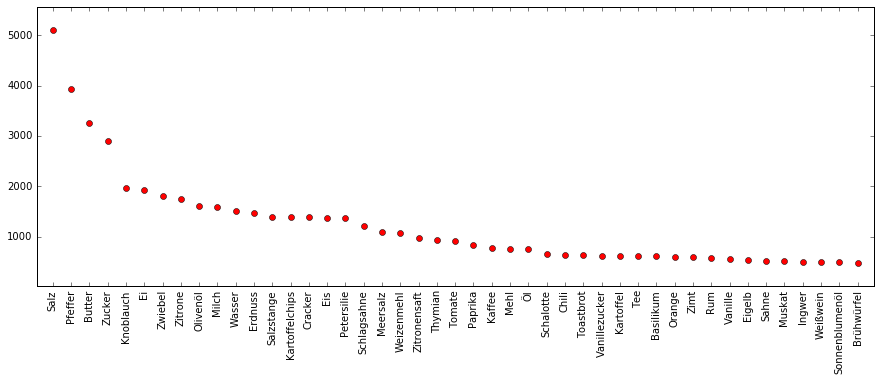

In [138]:
sorted_ingredient_counter = sorted(ingredient_counter.items(), reverse=True, key = lambda x:x[1])
keys, values = zip(*sorted_ingredient_counter)
number_of_examples = 45
plt.figure(figsize=(15,5))
plt.margins(x = 0.02, y = 0.1)
plt.plot(np.arange(number_of_examples),np.array(values)[:number_of_examples], "ro")
plt.xticks(np.arange(number_of_examples),keys[:number_of_examples],rotation="vertical")
plt.show()

In [139]:
all_ingredients = sorted(list(set([ing for recipe in recipe_ingredients for ing in recipe])))
ingredient_cooc = {ing1:{ing2: 0 for ing2 in all_ingredients} for ing1 in all_ingredients}
len(all_ingredients)

3139

In [140]:
num_of_errors=0
for i,recipe in enumerate(recipe_ingredients):
    for ingredient1, ingredient2 in itertools.permutations(recipe, 2):
        try:
            ingredient_cooc[ingredient1][ingredient2] += 1
        except KeyError:
            num_of_errors+=1
print num_of_errors
    

0


In [141]:
ingredient_cooc["Salz"]["Pfeffer"]

2948

In [142]:
ingredient_cooc_matrix = []
for ing1 in all_ingredients:
    row = []
    for ing2 in all_ingredients:
        row.append(ingredient_cooc[ing1][ing2])
    ingredient_cooc_matrix.append(row)
ingredient_cooc_matrix = np.array(ingredient_cooc_matrix)

In [143]:
valued_coocurrences = [(ing1, ing2, ingredient_cooc_matrix[i,j]) for i,ing1 in enumerate(all_ingredients) \
                       for j,ing2 in enumerate(all_ingredients) if i>j]
valued_coocurrences.sort(key=lambda x: x[2], reverse=True)
print valued_coocurrences[:10]

[(u'Salz', u'Pfeffer', 2948), (u'Salz', u'Butter', 1770), (u'Zwiebel', u'Pfeffer', 1350), (u'Zwiebel', u'Salz', 1322), (u'Pfeffer', u'Butter', 1276), (u'Pfeffer', u'Knoblauch', 1265), (u'Salz', u'Knoblauch', 1253), (u'Zucker', u'Salz', 1187), (u'Salz', u'Ei', 1154), (u'Pfeffer', u'Oliven\xf6l', 1099)]


In [144]:
ingredient_cooc_matrix.shape

(3139, 3139)

of course this matrix is very sparse and symmetric

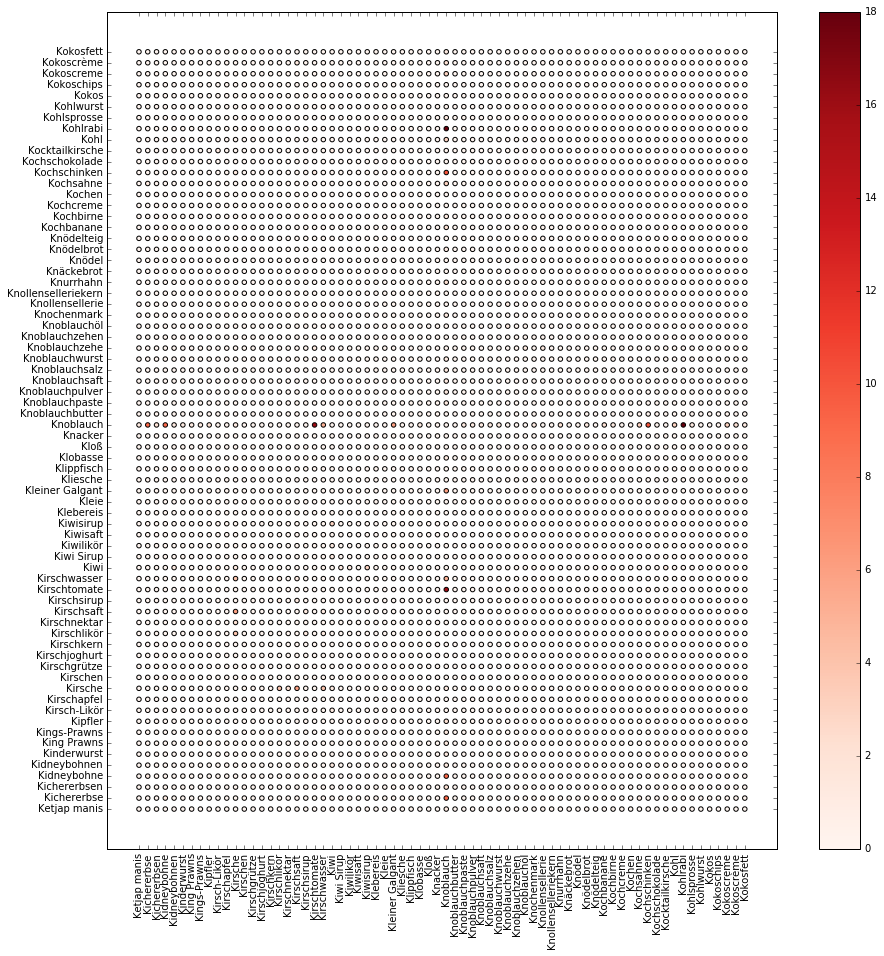

In [150]:
show_array_hotspots(ingredient_cooc_matrix[1300:1370,1300:1370], xlabels = all_ingredients[1300:1370], ylabels =all_ingredients[1300:1370], figsize=(15,15))

Jetzt finden wir heraus was alles gut zu Fenchel passt:

In [163]:
print "Das passt zu Fenchel:"
for candidate, frequency in sorted(ingredient_cooc["Fenchel"].items(), key = lambda x:x[1], reverse = True):
    if frequency>4:
        print candidate, frequency

Das passt zu Fenchel:
Salz 64
Pfeffer 61
Olivenöl 38
Knoblauch 33
Zitrone 31
Wasser 29
Zucker 26
Butter 26
Zwiebel 26
Koriander 26
Thymian 17
Meersalz 16
Tomate 15
Öl 15
Chili 14
Kümmel 13
Petersilie 13
Anis 12
Honig 11
Orange 10
Weizenmehl 10
Brühwürfel 9
Zimt 9
Hefe 9
Weißwein 8
Paprika 8
Limette 8
Sellerie 8
Lauch 8
Ei 8
Ingwer 8
Toastbrot 8
Schalotte 8
Zitronensaft 8
Nelke 7
Schlagsahne 7
Kartoffel 7
Forelle 7
Sonnenblumenöl 7
Fisch 6
Muskat 6
Mehl 6
Fond 6
Lorbeerblatt 5
Weißweinessig 5
Cocktailtomate 5
Pide 5
Kreuzkümmel 5
Balsamico 5
Roggenmehl 5
Lachs 5
Tomatenmark 5
Lorbeer 5
Kardamom 5
Parmesan 5
Rosmarin 5
Bockshornklee 5
Milch 5


In [148]:
def show_structure(element, depth = 0):
    if depth == 0:
        root = element.getroot()
        print "- ", root.tag
        element = root
    else:
        print " "*depth+ "\_ "+ element.tag 
    tag = ""
    tags = set()
    counter = 0
    for elem in element:

        if elem.tag not in tags:
        
            show_structure(elem, depth+2)                  
        else:
            if tag != elem.tag:
                counter = 0
                if counter > 1:
                    print " " * depth , "..."
        counter+=1
        tags.add(elem.tag)
        tag = elem.tag
    
    if len(element) > 0:
        print " "*depth , "..."

        

In [97]:
def show_array_hotspots(arr,xlabels=None,ylabels=None,color="Reds",marker_size=20,**kwargs):
    """Create a visual grid of an arrays positions. Values are represented by color coded dots"""
    plt.figure(**kwargs)
    plt.rc("grid",linestyle="--")
    x=np.arange(arr.shape[1])
    y=np.arange(arr.shape[0])
    xx,yy=np.meshgrid(x,y)
    
    colormap = plt.cm.get_cmap(color)
    if xlabels:
        plt.xticks(x,xlabels,rotation="vertical")
    else:
        plt.xticks(x,[])
    if ylabels:
        plt.yticks(y,ylabels)
    else:
        plt.yticks(x,[])

    sc=plt.scatter(xx,yy,c=arr,cmap=colormap,s=marker_size)
    plt.colorbar(sc)
    plt.show()